## Import Modules

In [75]:
from numpy.random import seed
seed(888)

import tensorflow as tf
tf.random.set_seed(404)

In [76]:
import os
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset

In [77]:
def load_csv_from_zip(zip_path: str, filename: str, header=None, as_array: bool = True) -> pd.DataFrame:
    """
    Load a CSV file directly from a ZIP archive.

    Parameters
    ----------
    zip_path : str
        Path to the ZIP archive.
    filename : str
        Name of the CSV file inside the ZIP archive.
    header : int, list of int, or None, default None
        Row(s) to use as the column names. Use None to keep all rows as data.
    as_array : bool, default True
        If True, return as a NumPy array. If False, return as a DataFrame.

    Returns
    -------
    np.ndarray or pd.DataFrame
        Data in array or DataFrame format.
    """
    with zipfile.ZipFile(zip_path) as z:
        with z.open(filename) as f:
            df = pd.read_csv(f, header=header)
    return df.values if as_array else df

ZIP_PATH = "data/MNIST.zip"

x_train_all = load_csv_from_zip(ZIP_PATH, "digit_xtrain.csv")
x_test = load_csv_from_zip(ZIP_PATH, "digit_xtest.csv")
y_train_all = load_csv_from_zip(ZIP_PATH, "digit_ytrain.csv")
y_test = load_csv_from_zip(ZIP_PATH, "digit_ytest.csv")

## EDA

x_train shape: (60000, 784)
y_train shape: (60000, 1)
x_test shape: (10000, 784)
y_test shape: (10000, 1)


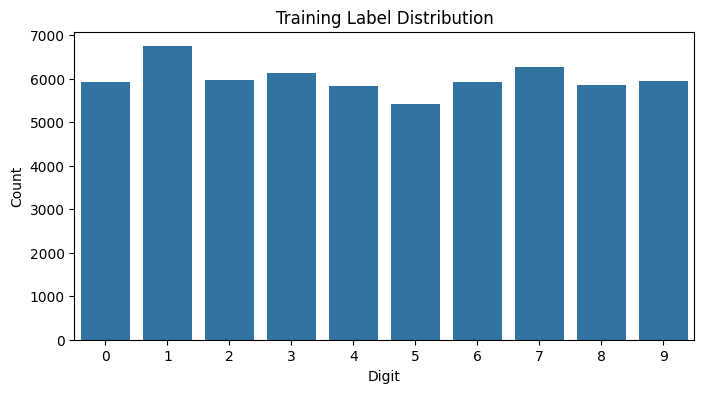

Missing values in x_train: 0
Missing values in y_train: 0
Missing values in x_test: 0
Missing values in y_test: 0
Pixel range in x_train: 0 to 255
Pixel range in x_test: 0 to 255


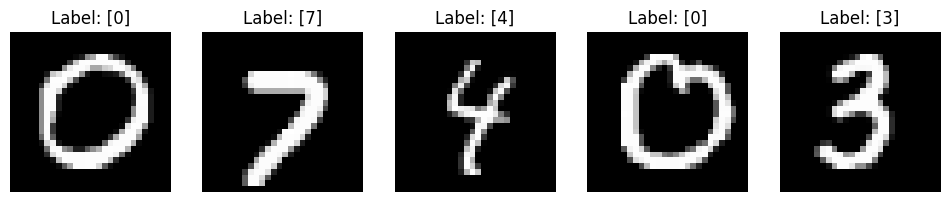

Train mean pixel value: 33.318421449829934
Train std pixel value: 78.56748998339742
Test mean pixel value: 33.791224489795916
Test std pixel value: 79.1724632222863


In [78]:
def eda_mnist(x_train, y_train, x_test, y_test, sample_size=5):
    # 1. Check shapes
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

    # 2. Check label distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y_train.flatten())
    plt.title("Training Label Distribution")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

    # 3. Check missing values
    print("Missing values in x_train:", np.isnan(x_train).sum())
    print("Missing values in y_train:", np.isnan(y_train).sum())
    print("Missing values in x_test:", np.isnan(x_test).sum())
    print("Missing values in y_test:", np.isnan(y_test).sum())

    # 4. Check pixel value ranges
    print("Pixel range in x_train:", x_train.min(), "to", x_train.max())
    print("Pixel range in x_test:", x_test.min(), "to", x_test.max())

    # 5. Show random samples
    plt.figure(figsize=(12, 3))
    indices = np.random.choice(len(x_train), sample_size, replace=False)
    for i, idx in enumerate(indices):
        img = x_train[idx].reshape(28, 28)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Label: {y_train[idx]}")
    plt.show()

    # 6. Basic statistics
    print("Train mean pixel value:", np.mean(x_train))
    print("Train std pixel value:", np.std(x_train))
    print("Test mean pixel value:", np.mean(x_test))
    print("Test std pixel value:", np.std(x_test))

eda_mnist(x_train_all, y_train_all, x_test, y_test)

## Data Pre-processing

### Re-scale

In [79]:
# Re-scale data between 0 - 1
x_train_all, x_test = x_train_all/255.0 , x_test / 255.0

### Convert target values to one-hot encoding

In [80]:
NUM_CLASSES = 10

y_train_all = np.eye(NUM_CLASSES)[y_train_all.ravel()]
y_test = np.eye(NUM_CLASSES)[y_test.ravel()]

### Create Validation set from training data

In [83]:
VALIDATION_SIZE = 10000

x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]